In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from utils import parse_stats, get_stat_dfs, trim_column_names, merge, MODEL_LABELS
matplotlib.rcParams.update({'font.size': 12})

In [2]:
sim_path = "../../results/faro/resnet34-sim/10_top9_twitter_1_1600_avgproc_min_int5m_reduced_6hr_augmented/latency_stats.pkl"
sim_df = parse_stats(sim_path)

/home/beomyeol/Workspace/ibm/faro/scripts/plots/utils.py:95: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(1, "avg_total_slo_rate", df.pop("avg_total_slo_rate"))
/home/beomyeol/Workspace/ibm/faro/scripts/plots/utils.py:96: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(1, "avg_total_utility", df.pop("avg_total_utility"))
/home/beomyeol/Workspace/ibm/faro/scripts/plots/utils.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

In [3]:
sim_df[sim_df.poisson == "42"].head()

,num_cpus,poisson,policy,pred_aggr,ws,idle_timeout,latency_estimator,model,model_config,utility,...,avg_effective_util_serve-cluster42,avg_util_serve-cluster45,avg_effective_util_serve-cluster45,avg_util_serve-cluster63,avg_effective_util_serve-cluster63,avg_util_serve-cluster96,avg_effective_util_serve-cluster96,avg_util_serve-cluster49,avg_effective_util_serve-cluster49,avg_total_effective_utility
11,320,42,hybrid_ai_pred_darts_cobyla_drop_linear_int_ut...,pred_none,420s,30s,max_latency,nhits,model_9,latency,...,0.985903,0.933137,0.934308,0.922151,0.924333,0.943949,0.953174,0.910682,0.942331,89.807689
12,320,42,aiad,,,30s,,,,latency,...,0.861691,0.828327,0.831509,0.810863,0.816371,0.816604,0.818351,0.856232,0.858605,83.483980
13,320,42,hybrid_ai_pred_darts_cobyla_drop_linear_int_ut...,pred_none,420s,30s,max_latency,nhits,model_9,latency,...,0.944122,0.919143,0.925351,0.895796,0.898436,0.900742,0.917874,0.854377,0.916434,91.290578
14,320,42,hybrid_ai_pred_darts,pred_max,420s,30s,max_latency,nhits,model_8,latency,...,0.501297,0.935486,0.935925,0.904099,0.906052,0.909847,0.909853,0.279242,0.282602,83.862091
15,320,42,hybrid_ai_pred_darts_cobyla_utility_latency_co...,pred_none,420s,30s,max_latency,nhits,model_9,latency,...,0.681775,0.929079,0.929941,0.906186,0.908133,0.954664,0.954664,0.907034,0.907490,90.056295


In [4]:
sim_policies = [
    "fairshare",
    "oneshot",
    "aiad",
    "hybrid_ai_pred_darts",  # mark

    "hybrid_ai_pred_darts_cobyla_utility_latency_coldstart_mdc0.99_adjust_pureminmax",  # faro fair
    "hybrid_ai_pred_darts_cobyla_utility_latency_coldstart_mdc0.99_adjust",  # faro sum
    "hybrid_ai_pred_darts_cobyla_utility_latency_coldstart_mdc0.99_adjust_minmax3",  # faro fair sum
    "hybrid_ai_pred_darts_cobyla_drop_linear_int_utility_latency_coldstart_mdc0.99_adjust", # faro penalty sum
    "hybrid_ai_pred_darts_cobyla_drop_linear_int_utility_latency_coldstart_mdc0.99_adjust_minmax3", # faro penalty fair sum

    # hierarchical optimization
    "hybrid_ai_pred_darts_cobyla_utility_latency_coldstart_mdc0.99_adjust_pureminmax_10group",  # faro fair
    "hybrid_ai_pred_darts_cobyla_utility_latency_coldstart_mdc0.99_adjust_10group",  # faro sum
    "hybrid_ai_pred_darts_cobyla_utility_latency_coldstart_mdc0.99_adjust_minmax3_10group",  # faro fair sum
    "hybrid_ai_pred_darts_cobyla_drop_linear_int_utility_latency_coldstart_mdc0.99_adjust_10group", # faro penalty sum
    "hybrid_ai_pred_darts_cobyla_drop_linear_int_utility_latency_coldstart_mdc0.99_adjust_minmax3_10group", # faro penalty fair sum
]
labels = [
    "FairShare",
    "Oneshot",
    "AIAD",
    "MArk/Cocktail/Barista",

    "Faro-Fair",
    "Faro-Sum",
    "Faro-FairSum",
    "Faro-PenaltySum",
    "Faro-PenaltyFairSum",

    "Faro-Fair(GROUP10)",
    "Faro-Sum(GROUP10)",
    "Faro-FairSum(GROUP10)",
    "Faro-PenaltySum(GROUP10)",
    "Faro-PenaltyFairSum(GROUP10)",
]
sim_labels = {
    policy: label for policy, label in zip(sim_policies, labels)
}
model_labels = MODEL_LABELS

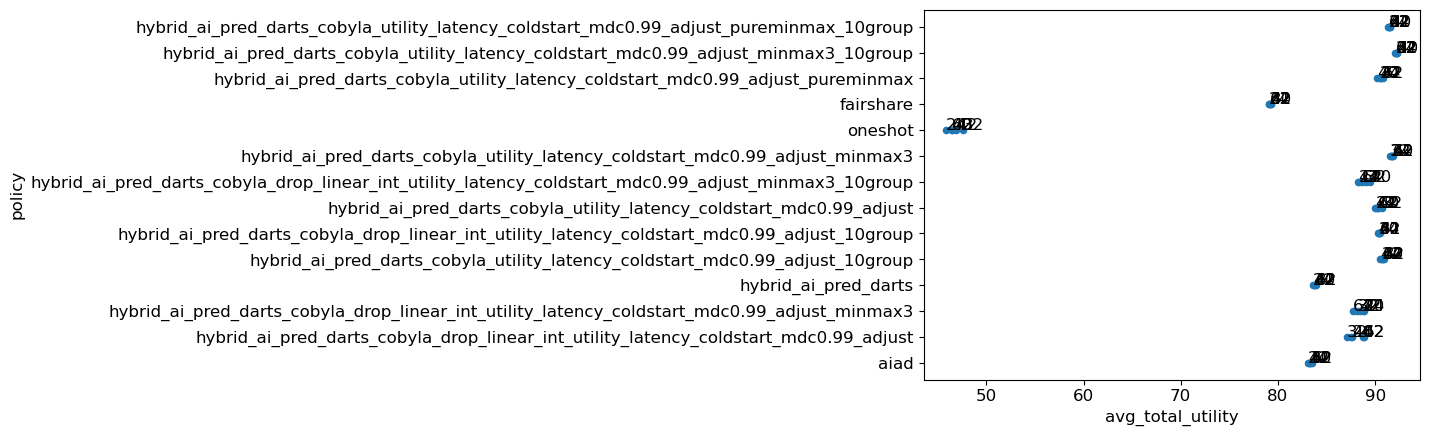

In [5]:
# visualize values for each policy
df = sim_df[sim_df.num_cpus == "320"]
policies = sim_policies
labels = labels
model_labels = MODEL_LABELS
target_df = df[
    # & (df.latency_estimator != "max_latency")
    (df.latency_estimator != "p80_latency")
    & (df.policy != "_fairshare")
    # & (df.pred_aggr != "pred_max") & (df.pred_aggr != "pred_p80")
    & (df.pred_aggr != "pred_p80") & (df.pred_aggr != "pred_avg") #& (df.pred_aggr != "pred_max")
    # & (df.pred_aggr != "pred_p80") & (df.pred_aggr != "pred_avg") & (df.pred_aggr != "pred_none")
    & (df.model_config != "model_4") & (df.model_config != "model_5") & (df.model_config != "model_6") # & (df.model_config != "model_8")
    & (df.model_config != "model_10")
    & (df.ws != "300s") & (df.ws != "480s")
    & (df.idle_timeout != "5s")
    & (~df.policy.str.endswith("utility_latency"))
    & (~df.policy.str.contains("scale"))
    & (~df.policy.str.contains("w_current"))
    & (~df.policy.str.contains("sqrt"))
    & (~df.policy.str.contains("cbrt"))
    & (~df.policy.str.contains("weighted"))
].copy()

ax = target_df.plot.scatter(x="avg_total_utility", y="policy")
for i, point in target_df.iterrows():
    ax.annotate(point["poisson"], (point["avg_total_utility"], point["policy"]))

# ax = target_df.plot.scatter(x="avg_total_slo_rate", y="policy")
# for i, point in target_df.iterrows():
#     ax.annotate(point["poisson"], (point["avg_total_slo_rate"], point["policy"]))

In [6]:
num_cpus = 320
sim_cluster_util_df, sim_cluster_slo_df, sim_cluster_effective_util_df, sim_avg_util_df, sim_slo_rates_df, sim_avg_effective_util_df = get_stat_dfs(sim_df[sim_df.num_cpus == str(num_cpus)], sim_policies, sim_labels, model_labels)

cluster_utils
FairShare 5
Oneshot 5
AIAD 5
MArk/Cocktail/Barista 420s model_8 5
Faro-Fair 420s model_9 5
Faro-Sum 420s model_9 5
Faro-FairSum 420s model_9 5
Faro-PenaltySum 420s model_9 5
Faro-PenaltyFairSum 420s model_9 5
Faro-Fair(GROUP10) 420s model_9 5
Faro-Sum(GROUP10) 420s model_9 5
Faro-FairSum(GROUP10) 420s model_9 5
Faro-PenaltySum(GROUP10) 420s model_9 5
Faro-PenaltyFairSum(GROUP10) 420s model_9 5
cluster_effective_utils
FairShare 5
Oneshot 5
AIAD 5
MArk/Cocktail/Barista 420s model_8 5
Faro-Fair 420s model_9 5
Faro-Sum 420s model_9 5
Faro-FairSum 420s model_9 5
Faro-PenaltySum 420s model_9 5
Faro-PenaltyFairSum 420s model_9 5
Faro-Fair(GROUP10) 420s model_9 5
Faro-Sum(GROUP10) 420s model_9 5
Faro-FairSum(GROUP10) 420s model_9 5
Faro-PenaltySum(GROUP10) 420s model_9 5
Faro-PenaltyFairSum(GROUP10) 420s model_9 5
cluster_slo
FairShare 5
Oneshot 5
AIAD 5
MArk/Cocktail/Barista 420s model_8 5
Faro-Fair 420s model_9 5
Faro-Sum 420s model_9 5
Faro-FairSum 420s model_9 5
Faro-PenaltyS

In [7]:
num_jobs = len(sim_avg_util_df)
print(num_jobs)

100


In [8]:
dfs = [sim_cluster_util_df, sim_cluster_slo_df, sim_cluster_effective_util_df, sim_avg_util_df, sim_slo_rates_df, sim_avg_effective_util_df]

for df in dfs:
    trim_column_names(df)

In [9]:
lost_sim_cluster_util_df = (num_jobs - sim_cluster_util_df)
lost_sim_cluster_slo_df = (1 - sim_cluster_slo_df)
if num_cpus == 16:
    targets = ["FairShare", "Oneshot", "AIAD", "MArk/Cocktail/Barista", "Faro-Sum"]
else:
    # targets = ["FairShare", "Oneshot", "AIAD", "MArk/Cocktail/Barista", "Faro-FairSum"]
    # Use hierarchical data
    targets = ["FairShare", "Oneshot", "AIAD", "MArk/Cocktail/Barista", "Faro-FairSum(GROUP10)"]

In [10]:
pd.concat([
    lost_sim_cluster_util_df.mean(axis=0)[targets].round(2),
    lost_sim_cluster_util_df.std(axis=0)[targets].round(2)
], axis=1).transpose()

,FairShare,Oneshot,AIAD,MArk/Cocktail/Barista,Faro-FairSum(GROUP10)
0,20.82,53.37,16.72,16.24,7.83
1,0.08,0.63,0.16,0.13,0.07


In [11]:
pd.concat([
    lost_sim_cluster_slo_df.mean(axis=0)[targets].round(2),
    lost_sim_cluster_slo_df.std(axis=0)[targets].round(2)
], axis=1).transpose()

,FairShare,Oneshot,AIAD,MArk/Cocktail/Barista,Faro-FairSum(GROUP10)
0,0.16,0.48,0.09,0.13,0.03
1,0.00,0.01,0.00,0.00,0.00


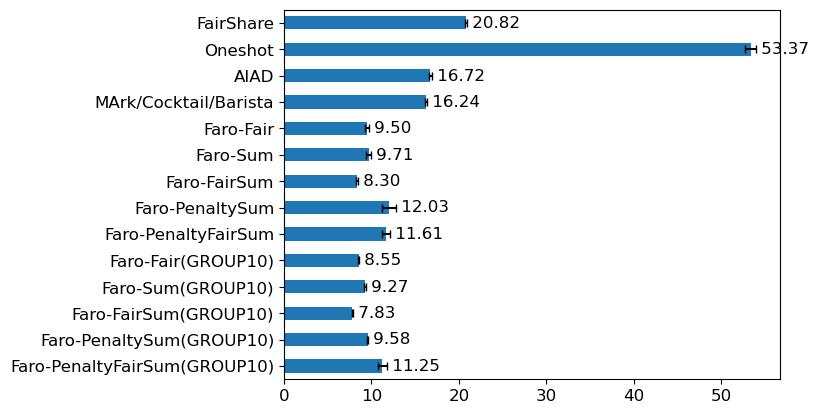

In [12]:
ax = lost_sim_cluster_util_df.mean(axis=0).plot.barh(xerr=lost_sim_cluster_util_df.std(axis=0), capsize=3)
ax.invert_yaxis()
for bar in ax.containers:
    if isinstance(bar, matplotlib.container.BarContainer):
        ax.bar_label(bar, fmt=" %.2f")
ax.get_figure().savefig(f"images/{num_cpus}_cluster_lost_util.eps", bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


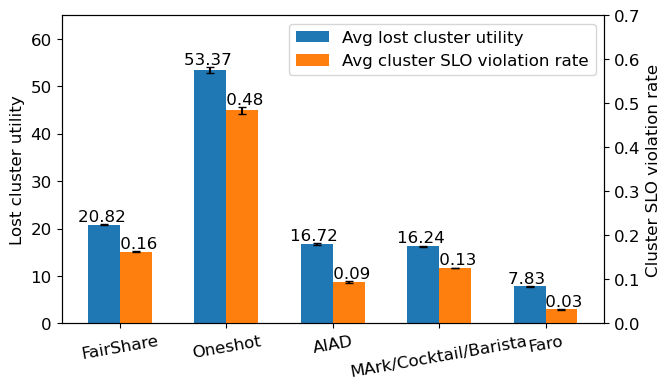

In [13]:
# figsize=(7.4, 4.8)
# figsize=(8.4, 4.8)
figsize=(7, 4)

merged_df = pd.concat([
    lost_sim_cluster_util_df[targets].mean(axis=0),
    lost_sim_cluster_slo_df[targets].mean(axis=0),
], axis=1).rename(columns={0: "Avg lost cluster utility", 1: "Avg cluster SLO violation rate"})
merged_std_df = pd.concat([
    lost_sim_cluster_util_df[targets].std(axis=0),
    lost_sim_cluster_slo_df[targets].std(axis=0),
], axis=1).rename(columns={0: "Avg lost cluster utility", 1: "Avg cluster SLO violation rate"})
ax = merged_df.plot.bar(secondary_y="Avg cluster SLO violation rate", mark_right=False, figsize=figsize, width=0.6, yerr=merged_std_df, capsize=3)

ax.set_ylim(top=65)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xlabel("")
ax.set_ylabel("Lost cluster utility")

new_labels = []
for text in ax.get_xticklabels():
    splits = text.get_text().split("-")
    text.set_text(splits[0])
    new_labels.append(text)
ax.set_xticklabels(new_labels, rotation=0)

right_ax = ax.right_ax
right_ax.set_ylim(top=0.7)
right_ax.set_ylabel("Cluster SLO violation rate")

for bar in ax.containers:
    if isinstance(bar, matplotlib.container.BarContainer):
        ax.bar_label(bar, fmt="%.2f ")

for bar in right_ax.containers:
    if isinstance(bar, matplotlib.container.BarContainer):
        right_ax.bar_label(bar, fmt=" %.2f")

ax.set_xticklabels(ax.get_xticklabels(), rotation=10)
ax.get_figure().savefig(f"images/{num_cpus}_avg_lost_cluster_utility_slo_real.eps", bbox_inches='tight')